## DAIICT Canteen Management System




### What is sentiment analysis?
Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text. Sentiment is often framed as a binary distinction (positive vs. negative), but it can also be a more fine-grained, like identifying the specific emotion an author is expressing (like fear, joy or anger).

For this project,the goal is to to classify Food reviews based on customers' text.

## Note: This is a work in progress. 
### For Implementing the model for mobile devices it needs to be implemented in Tensorflow Lite. 
### Current model is implemented in Tensorflow for testing purposes and is not optimized for mobile devices.

#### The column or features in the dataset:
 - Id
 - ProductId — unique identifier for the product
 - UserId — unqiue identifier for the user
 - ProfileName
 - HelpfulnessNumerator — number of users who found the review helpful
 - HelpfulnessDenominator — number of users who indicated whether they found the review helpful or not
 - Score — rating between 1 and 5
 - Time — timestamp for the review
 - Summary — brief summary of the review
 - Text — text of the review

### Importing Libraries

In [2]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
print(os.listdir("../input"))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import json

['fasttext-crawl-300d-2m', 'amazon-fine-food-reviews']


## Loading the dataset

In [3]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
##Removing the Duplicates if any
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [9]:
#Check for the null values in each column
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [10]:
##Remove the NaN values from the dataset
df.isnull().sum()
df.dropna(how='any',inplace=True)

In [11]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 1.0, 'Score')

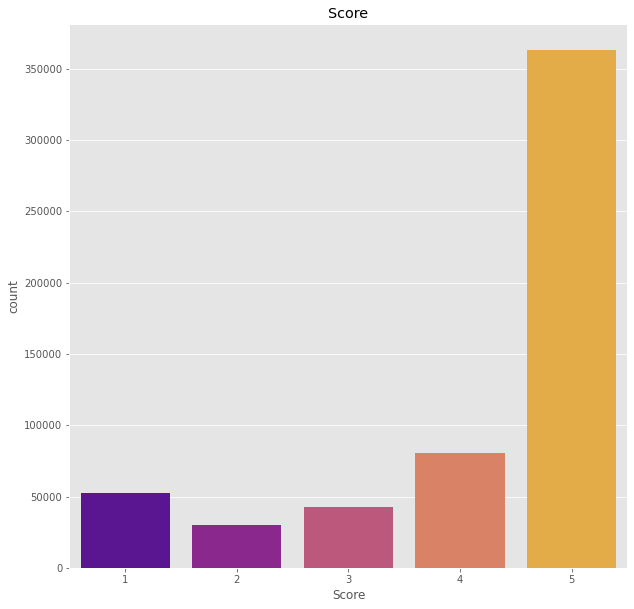

In [12]:
import seaborn as sns
sns.countplot(df['Score'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Score')

In [13]:
rating_df = pd.DataFrame(df, columns=['Score', 'Text'])

print(rating_df.shape)
rating_df.head()

(568411, 2)


,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [14]:
rating_df['Score'].astype('category').value_counts()

5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64

In [15]:
dummies = pd.get_dummies(rating_df['Score'])
dummies.head()

,1,2,3,4,5
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,0,0,0,1


### Text Preprocessing

In [16]:
## Lower Casing
rating_df['Text'] = rating_df['Text'].str.lower()
rating_df.head()

,Score,Text
0,5,i have bought several of the vitality canned d...
1,1,product arrived labeled as jumbo salted peanut...
2,4,this is a confection that has been around a fe...
3,2,if you are looking for the secret ingredient i...
4,5,great taffy at a great price. there was a wid...


In [17]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

rating_df['Text'] = rating_df['Text'].apply(lambda text: remove_punctuation(text))
rating_df.head()

,Score,Text
0,5,i have bought several of the vitality canned d...
1,1,product arrived labeled as jumbo salted peanut...
2,4,this is a confection that has been around a fe...
3,2,if you are looking for the secret ingredient i...
4,5,great taffy at a great price there was a wide...


In [18]:
## Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

rating_df['Text'] = rating_df['Text'].apply(lambda text: remove_stopwords(text))
rating_df.head()

,Score,Text
0,5,bought several vitality canned dog food produc...
1,1,product arrived labeled jumbo salted peanutsth...
2,4,confection around centuries light pillowy citr...
3,2,looking secret ingredient robitussin believe f...
4,5,great taffy great price wide assortment yummy ...


In [19]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

rating_df['Text'] = rating_df['Text'].apply(lambda text: remove_urls(text))
rating_df.head()

,Score,Text
0,5,bought several vitality canned dog food produc...
1,1,product arrived labeled jumbo salted peanutsth...
2,4,confection around centuries light pillowy citr...
3,2,looking secret ingredient robitussin believe f...
4,5,great taffy great price wide assortment yummy ...


In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    rating_df['Text'], 
    dummies, 
    test_size=0.1, random_state=19
)

In [21]:
def build_matrix(word_index, path):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    def load_embeddings(path):
        with open(path) as f:
            embedding_index = {}
            
            for line in tqdm(f):
                word, arr = get_coefs(*line.strip().split(' '))    
                if word in word_index:
                    embedding_index[word] = arr
            
        return embedding_index

    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in tqdm(word_index.items()):
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [22]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
 
    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = Dense(512, activation='relu')(hidden)
    
    result = Dense(5, activation='softmax')(hidden)
    
    model = Model(inputs=words, outputs=result)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [23]:
%%time
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

CPU times: user 23.5 s, sys: 52.7 ms, total: 23.6 s
Wall time: 23.6 s


I have used 300-dimensional pretrained FastText English word vectors released by Facebook.

In [24]:
embedding_matrix = build_matrix(tokenizer.word_index, '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec')

2000001it [02:29, 13333.94it/s]
100%|██████████| 240537/240537 [00:00<00:00, 467342.87it/s]


In [25]:
maxlen=512
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=512)
x_test = sequence.pad_sequences(x_test, maxlen=512)

In [ ]:
model = build_model(embedding_matrix)
model.summary()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    callbacks=[checkpoint],
    epochs=50,
    validation_split=0.1
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    72161400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 300)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 512)    1140736     spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
print(history)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()